In [1]:
import numpy as np                              #array manipulation and math
from matplotlib import pyplot as plt            #plotting the data
from netCDF4 import Dataset,num2date            #read netcdf
import matplotlib.patches                        
import matplotlib.dates as mpD                  #dates in plots
import cartopy.crs as ccrs                      #mapping module
import cartopy.feature as cfeature              #to put features in a map
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER  #latitude, longitude formats
from datetime import datetime                   #transform dates to python dates
from datetime import timedelta   

In [2]:
nc = Dataset('/net/centaure/local/tmp/1/mbarros/EXP_2005to2008/TRA02_SEL01_DET05_eddies_r3km_2005M1_2008M12.nc','r')

In [ ]:
#To see the variables names
print(nc.variables.keys())

In [ ]:
Ampl_all[Ampl_all<0]

In [3]:
#getting the variables from nc 
lat_all = nc.variables['lat'][:]
lon_all = nc.variables['lon'][:] #tem q colocar [:]
vort_all = nc.variables['Vorticity'][:]
Energy_all = nc.variables['Energy'][:]
Ampl_all = nc.variables['Amplitude'][:]
U_all = nc.variables['U'][:]
V_all = nc.variables['V'][:]
time_all = nc.variables['time'][:]
radius_all = nc.variables['Radius'][:]
ID_all = nc.variables['ID'][:]
nc.close()

In [6]:
# Convert julian date to gregorian date and vice versa
dateref=datetime(1900,1,1)
def jd_to_date(jd, date_ref):
    date = [date_ref + timedelta(days=x) for x in jd]
    return date

def greg_to_jd(dategreg,dateref):
    tmp=dategreg-dateref
    return np.float(tmp.days) + np.float(tmp.seconds)/86400

In [ ]:
#coodenates of the Agulhas ridge:
#min lat: -44.5809°
#min lon: 3.4753°
#max lat: -40.2935°
#max lon: 15.55° 

In [ ]:
import scipy.io as scio
f = scio.loadmat('/home/mbarros/Documents/rotinas/MATAB/agulhas_ridge.mat')
#cyclones
lat_line= f["lat"][:]
lon_line=f["lon"][:]

In [ ]:
lat_line=np.array(lat_line)
lon_line=np.array(lon_line)

In [32]:
path2 = '/data0/project/benguela/BUIC/OUTPUT/R3KM/BENGSAFE_R3KM_V2c_EXTRACTED_eddydetect_fulllong/roms_avg_Y2005M6.nc'
nc2 = Dataset(path2,'r')

In [33]:
#separating each variable
#lon, lat and h  only need to be read once
lon = nc2.variables['lon_rho'][:] #tem q colocar [:]
lat = nc2.variables['lat_rho'][:]
bathy = nc2.variables['h'][:]

nc2.close()

In [ ]:
proj=ccrs.PlateCarree()  
#features 
step=15
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
#the plot in loop
fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
    #ax.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
ax.add_feature(land_10m)
    #Let's plot Bathymetry
ctf = ax.contour(lon,lat,bathy,cmap='gray')
ax.plot(lon_line,lat_line,'r')
fig.savefig("agulhas_ridge.png")

In [ ]:
#contruct the distance matrix
#to calculate the distances in a sphere

def dist_spheric(lat1,lon1,lat2,lon2): # function that takes angles in deg
    #return mastrix dist of size NI*ND
    #NI: size of lat2
    #ND size of lat1
    # arguments must be vectors (NOT 2D arrays)
    R= 6371.008*10**3
    NI=np.size(lat2)
    ND=np.size(lat1)

    l=np.abs(np.dot(np.transpose(lon2),np.ones((1,ND)))- np.dot(np.ones((NI,1)),lon1))
    l[l>=180]=360-l[l>=180]

    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    l=np.radians(l)

    dist=R*np.arctan2(np.sqrt((np.sin(l)*np.dot(np.transpose(np.cos(lat2)),np.ones((1,ND))))**2 \
                        +(np.dot(np.transpose(np.sin(lat2)),np.cos(lat1)) \
                         - np.dot(np.transpose(np.cos(lat2)),np.sin(lat1))*np.cos(l))**2 \
                        ),
                          np.dot(np.transpose(np.sin(lat2)),np.sin(lat1))+\
                          np.dot(np.transpose(np.cos(lat2)),np.cos(lat1))*np.cos(l) \
                          )

    return dist

In [ ]:
ID_inridge=[];

In [ ]:
#to look for each ID if they at some point got close to the ridge
#first we list the list of different eddies IDs from eddies bigger than 100km#
IDs=np.unique(ID_all)
#now we investigate each eddy, choosing only the ones that got close to the ridge. The criteria was the maximum radius, in order to not exclude the biggest eddies
for id in IDs:
    loneddy=np.array([lon_all[ID_all==id]])                 #separating the positions of the eddy of an specific ID
    lateddy=np.array([lat_all[ID_all==id]])   
    dist_ridge=dist_spheric(lateddy,loneddy,lat_line,lon_line)    #calculating the distance between each position
    inridge=np.array(np.where(dist_ridge<=np.max(radius_all)))
    if inridge.size==0:
        pass
    else:
        ID_inridge.append(id)
    

In [ ]:
for id in ID_inridge:
    raeddy=radius_all[ID_all==id]   #calculating the distance between each position
    is50=np.array(np.where(raeddy>50000))
    if is50.size==0:
        pass
    else:
        id_50.append(np.int(id))


In [ ]:
id_100=[]

In [ ]:
for id in ID_inridge:
    raeddy=radius_all[ID_all==id]   #calculating the distance between each position
    is100=np.array(np.where(raeddy>100000))
    if is100.size==0:
        pass
    else:
        id_100.append(np.int(id))


In [ ]:
print(np.shape(id_50))
print(np.shape(id_100))

In [ ]:
#plot the trajectories of these eddies
proj=ccrs.PlateCarree()  
#features 
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
#the plot in loop
for id in range(len(id_50)):
    fig=plt.figure(figsize=(12,10))
    ax=plt.axes(projection=proj)
    #ax.add_feature(cfeature.COASTLINE)     #Add Coastlines
    gl=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    ax.add_feature(land_10m)
    #Let's plot Bathymetry
    ctf = ax.contour(lon,lat,bathy,cmap='gray')
    loneddy=np.array(lon_all[ID_all==id_50[id]])                                  #separating the positions of the eddy of an specific ID
    lateddy=np.array(lat_all[ID_all==id_50[id]]) 
    ax.plot(loneddy,lateddy)
    id_traj=id_50[id]
    plt.savefig("Map_traj_{id_traj}.png".format(id_traj=np.int(id_traj)))
                                      #separating the positions of the eddy of an specific ID
#fig.savefig("aceddies_ridge.png")

In [ ]:
#plot the trajectories of these eddies
proj=ccrs.PlateCarree()  
#features 
step=15
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
#the plot in loop
fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
    #ax.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
ax.add_feature(land_10m)
    #Let's plot Bathymetry
ctf = ax.contour(lon,lat,bathy,cmap='gray')
for id in id_100:
    loneddy=np.array(lon_all[ID_all==id])                                   #separating the positions of the eddy of an specific ID
    lateddy=np.array(lat_all[ID_all==id]) 
    #vorteddy=np.array(vort_50[ID_50==id])  
#if np.sign(np.mean(vorteddy))==np.sign(np.mean(lateddy)):
 #       pass
  #  else:
    ax.plot(loneddy,lateddy)

                                     #separating the positions of the eddy of an specific ID
#fig.savefig("aceddies_ridge.png")

In [ ]:
#plot the trajectories of these eddies
proj=ccrs.PlateCarree()  
#features 
step=15
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
#the plot in loop
fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
    #ax.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
ax.add_feature(land_10m)
    #Let's plot Bathymetry
ctf = ax.contour(lon,lat,bathy,cmap='gray')
loneddy=np.array(lon_all[ID_all==id_50[26]])                                   #separating the positions of the eddy of an specific ID
lateddy=np.array(lat_all[ID_all==id_50[26]]) 
    #vorteddy=np.array(vort_50[ID_50==id])  
#if np.sign(np.mean(vorteddy))==np.sign(np.mean(lateddy)):
 #       pass
  #  else:
ax.plot(loneddy,lateddy)

                                     #separating the positions of the eddy of an specific ID
#fig.savefig("aceddies_ridge.png")

In [ ]:
days = []
vort = []
radius = []
time_ridge = []

In [ ]:
id_50

In [ ]:
#to see if they are cyclones or anticyclones
for id in id_50:
    vorteddy=np.array(vort_all[ID_all==id])
    radeddy=np.array(radius_all[ID_all==id])
    teddy=time_all[ID_all==id]
    loneddy=np.array([lon_all[ID_all==id]])                 #separating the positions of the eddy of an specific ID
    lateddy=np.array([lat_all[ID_all==id]])   
    dist_ridge=dist_spheric(lateddy,loneddy,lat_line,lon_line)    #calculating the distance between each position
    inridge=np.array(np.where(np.min(dist_ridge,axis=0)<radeddy))
    #days.append(len(teddy))
    #vort.append(np.mean(vorteddy))
    #time_ridge.append(inridge.size)
    radius.append(np.mean(radeddy))
    


In [ ]:
for id in id_50:
    loneddy=np.array([lon_all[ID_all==id]])                 #separating the positions of the eddy of an specific ID
    lateddy=np.array([lat_all[ID_all==id]])   
    dist_ridge=dist_spheric(lateddy,loneddy,lat_line,lon_line)    #calculating the distance between each position
    radeddy=np.array(radius_all[ID_all==id])
    teddy=teste[ID_all==id]
    inridge=np.array(np.where(np.min(dist_ridge,axis=0)<radeddy))
    if inridge.size==0:
        i=i+1
        pass
    else:
        for jj in range(inridge.size):
            month_inridge[i,jj]=teddy[jj].month
        i=i+1

In [ ]:
#ID - eddies of interest
id_plot=[15,32,550,1109,1182,1288,1758,3506,3818,3841,4043,4312,5617,5962,7471,7774,8128,8560,9051,9302,9376]

In [4]:
#ID - eddies of interest during winter
id_plot_winter=[1109,1182,1288,3506,3818,3841,5962,8128,8560,7774]

In [ ]:
#plot the trajectories of these eddies
proj=ccrs.PlateCarree()  
#features 
step=15
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
#the plot in loop
fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
    #ax.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
ax.add_feature(land_10m)
    #Let's plot Bathymetry
ctf = ax.contour(lon,lat,bathy,cmap='gray')
for ii in range(len(id_plot_winter)):
    loneddy=lon_all[ID_all==id_plot_winter[ii]]                                  #separating the positions of the eddy of an specific ID
    lateddy=lat_all[ID_all==id_plot_winter[ii]]
    veddy=vort_all[ID_all==id_plot_winter[ii]]
    if np.sign(np.mean(veddy))==np.mean(np.sign(np.mean(lateddy))):
        pass
    else:
        ax.plot(loneddy,lateddy,'r')
        ax.text(loneddy[0],lateddy[0],str(id_plot_winter[ii]),fontsize=14)
        #ax.text(lon_all[np.floor(time_all)====np.floor(time[jj])],lat_all[np.floor(time_all)==np.floor(time[jj])],str(greg[jj]),fontsize=14)
#fig.savefig("wintereddies2_ridge.png")

In [ ]:
#to know the dates for generating the maps
teddy=time_all[ID_all==id_plot_winter[-2]]

In [ ]:
gregsd=jd_to_date(teddy,dateref)

In [ ]:
greg2=jd_to_date(np.floor(teddy),dateref)

In [ ]:
print(gregsd[0])
print(gregsd[-1])
print([greg2[-1]])

In [ ]:
print(teddy[1])

print(np.int(teddy[1]))
np.floor(teddy).any()==np.floor(time[9])

# Plotting 7774 different phases 

In [ ]:
#Plotting the eddy number 7774 from 
path = '/data0/project/benguela/BUIC/OUTPUT/R3KM/BENGSAFE_R3KM_V2c_EXTRACTED_eddydetect_fulllong/'
files = ['roms_avg_Y2008M3.nc','roms_avg_Y2008M4.nc','roms_avg_Y2008M5.nc']
print(np.size(files))

In [ ]:
days_plot=[39520,39558,39573,39576]

In [43]:
#to know the dates and eddy location for generating the maps
#the main vortex
teddy1 = time_all[ID_all==id_plot_winter[-1]]
lateddy1 = lat_all[ID_all==id_plot_winter[-1]]
loneddy1 = lon_all[ID_all==id_plot_winter[-1]]

#the vortex after splitting
teddy2 = time_all[ID_all==id_plot_winter[7]]
lateddy2 = lat_all[ID_all==id_plot_winter[7]]
loneddy2 = lon_all[ID_all==id_plot_winter[7]]


In [ ]:
loneddy1=np.array([lon_all[ID_all==id_plot_winter[-1]]])
lateddy1=np.array([lat_all[ID_all==id_plot_winter[-1]]])

In [ ]:
#to calculate how many day the eddies interacted with the bridge
print(np.shape(loneddy1))
print(np.shape(lateddy1))
dist=dist_spheric(lateddy1,np.array(loneddy1),np.array(lat_line),np.array(lon_line))    #calculating the distance between each position
inridge=np.array(np.where(np.min(dist,axis=0)<radeddy))
  

In [ ]:
np.shape(inridge)
print(inridge)

In [ ]:
print(loneddy1[:,11])
print(lateddy1[:,11])
print(teddy1[11])

In [ ]:
nc3 = Dataset(path+files[2],'r')
time = nc3['scrum_time'][:]
time = time/(24*3600);
#zeta = nc3.variables['zeta'][np.where(np.floor(time)==np.floor(days_plot[3]))][0]
#tt= time [np.where(np.floor(time)==np.floor(days_plot[3]))]
print(np.floor(time))
print(np.shape(tt))
print(loneddy1[np.floor(teddy1)==np.floor(tt)])

In [ ]:
path = '/data0/project/benguela/BUIC/OUTPUT/R3KM/BENGSAFE_R3KM_V2c_EXTRACTED_eddydetect_fulllong/'
files = ['roms_avg_Y2008M3.nc','roms_avg_Y2008M4.nc','roms_avg_Y2008M5.nc','roms_avg_Y2005M10.nc']
print(np.size(files))
nc3 = Dataset(path+files[0],'r')
time = nc3['scrum_time'][:]
time = time/(24*3600);
zeta = nc3.variables['zeta'][np.where(np.floor(time)==np.floor(days_plot[0]))][0]
tt= time [np.where(np.floor(time)==np.floor(days_plot[0]))]
greg = jd_to_date(tt,dateref)

fig=plt.figure(figsize=(30,25))
proj=ccrs.PlateCarree()  
#features 
step=15
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
ax1 = plt.subplot(2, 2, 1, projection=proj)
ax1.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl1=ax1.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 14, 'color': 'black'}
gl1.ylabel_style = {'size': 14, 'color': 'black'}
ax1.add_feature(land_10m)
ctf1 = ax1.contour(lon,lat,zeta,np.linspace(-1.25,1.25,25),cmap='jet')
ax1.contour(lon,lat,bathy,cmap='gray')
ax1.scatter(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],color='k')
ax1.text(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],str(7774),fontsize=14)
del zeta

nc3 = Dataset(path+files[1],'r')
time = nc3['scrum_time'][:]
time = time/(24*3600);
zeta = nc3.variables['zeta'][np.where(np.floor(time)==np.floor(days_plot[1]))][0]
tt= time [np.where(np.floor(time)==np.floor(days_plot[1]))]
greg = jd_to_date(tt,dateref)
ax2 = plt.subplot(2, 2, 2, projection=proj)
ax2.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl2=ax2.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl2.xlabels_top = False
gl2.ylabels_right = False
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 14, 'color': 'black'}
gl2.ylabel_style = {'size': 14, 'color': 'black'}
ax2.add_feature(land_10m)
ctf2 = ax2.contour(lon,lat,zeta,np.linspace(-1.25,1.25,25),cmap='jet')
ax2.contour(lon,lat,bathy,cmap='gray')
ax2.scatter(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],color='k')
ax2.text(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],str(7774),fontsize=14)
del zeta, time

nc3 = Dataset(path+files[2],'r')
time = nc3['scrum_time'][:]
time = time/(24*3600);
tt= time [np.where(np.floor(time)==np.floor(days_plot[2]))]
zeta = nc3.variables['zeta'][np.where(np.floor(time)==np.floor(days_plot[2]))][0]
greg = jd_to_date(time,dateref)
ax3 = plt.subplot(2, 2, 3, projection=proj)
ax3.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl3=ax3.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl3.xlabels_top = False
gl3.ylabels_right = False
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER
gl3.xlabel_style = {'size': 14, 'color': 'black'}
gl3.ylabel_style = {'size': 14, 'color': 'black'}
ax3.add_feature(land_10m)
ctf3 = ax3.contour(lon,lat,zeta,np.linspace(-1.25,1.25,25),cmap='jet')
ax3.contour(lon,lat,bathy,cmap='gray')
ax3.scatter(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],color='k')
ax3.text(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],str(7774),fontsize=14)
del zeta 

tt= time [np.where(np.floor(time)==np.floor(days_plot[3]))]
zeta = nc3.variables['zeta'][np.where(np.floor(time)==np.floor(days_plot[3]))][0]
greg = jd_to_date(time,dateref)
ax4 = plt.subplot(2, 2, 4, projection=proj)
ax4.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl4=ax4.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl4.xlabels_top = False
gl4.ylabels_right = False
gl4.xformatter = LONGITUDE_FORMATTER
gl4.yformatter = LATITUDE_FORMATTER
gl4.xlabel_style = {'size': 14, 'color': 'black'}
gl4.ylabel_style = {'size': 14, 'color': 'black'}
ax4.add_feature(land_10m)
ctf4 = ax4.contour(lon,lat,zeta,np.linspace(-1.25,1.25,25),cmap='jet')
ax4.contour(lon,lat,bathy,cmap='gray')
ax4.scatter(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],color='k')
ax4.text(loneddy1[np.floor(teddy1)==np.floor(tt)],lateddy1[np.floor(teddy1)==np.floor(tt)],str(7774),fontsize=14) 
ax4.scatter(loneddy2[0],lateddy2[0],color='k')
ax4.text(loneddy2[0],lateddy2[0],str(8128),fontsize=14) 
nc3.close()
fig.savefig("/home/mbarros/Documents/traj/Map_7774.png")

In [5]:
#Analyzing the evolution of the eddy characteristics
#separating the variables for eddy 7774
teddy1 = time_all[ID_all==id_plot_winter[-1]]
lateddy1 = lat_all[ID_all==id_plot_winter[-1]]
loneddy1 = lon_all[ID_all==id_plot_winter[-1]]
radeddy = radius_all[ID_all==id_plot_winter[-1]]
eneddy = Energy_all[ID_all==id_plot_winter[-1]]
ampeddy = Ampl_all[ID_all==id_plot_winter[-1]]


In [41]:
#to save the eddies variables in a pickle file
import pickle
# Saving the objects:
with open('eddy_7774.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([teddy1, lateddy1, loneddy1, radeddy,eneddy,ampeddy], f)

In [44]:
with open('eddy_8128.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([teddy2, lateddy2, loneddy2], f)

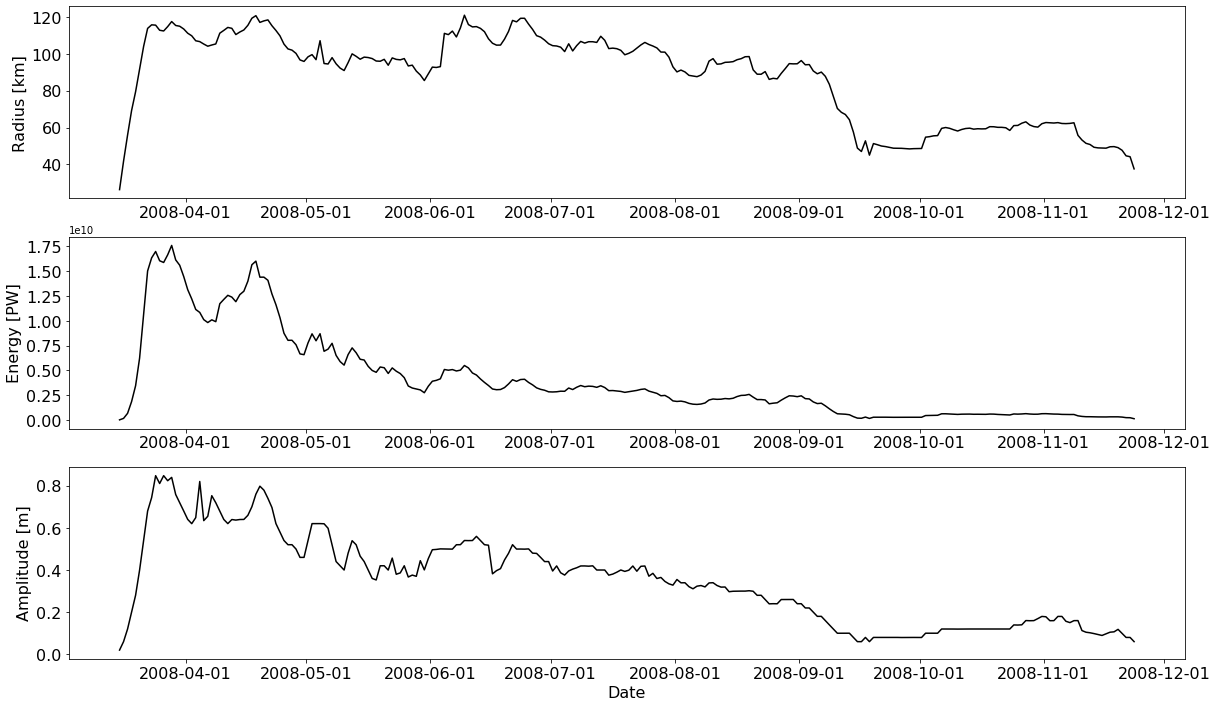

In [31]:
#radius
#creating the datevector
greg=jd_to_date(teddy1,dateref)
#the plot
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(20,12))
ax1.plot(greg,radeddy/1000,'k')
hfmt=mpD.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(hfmt)
for tickLabel in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    tickLabel.set_fontsize(fontsize = 16)
ax1.set_ylabel("Radius [km]", fontsize=16)

ax2.plot(greg,eneddy,'k')
hfmt=mpD.DateFormatter('%Y-%m-%d')
ax2.xaxis.set_major_formatter(hfmt)
for tickLabel in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    tickLabel.set_fontsize(fontsize = 16)
ax2.set_ylabel("Energy [PW]", fontsize=16)

ax3.plot(greg,ampeddy,'k')
hfmt=mpD.DateFormatter('%Y-%m-%d')
ax3.xaxis.set_major_formatter(hfmt)
for tickLabel in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    tickLabel.set_fontsize(fontsize = 16)
ax3.set_ylabel("Amplitude [m]", fontsize=16)
ax3.set_xlabel("Date",fontsize=16)
fig.savefig('7774_characteristics.png')
plt.show()


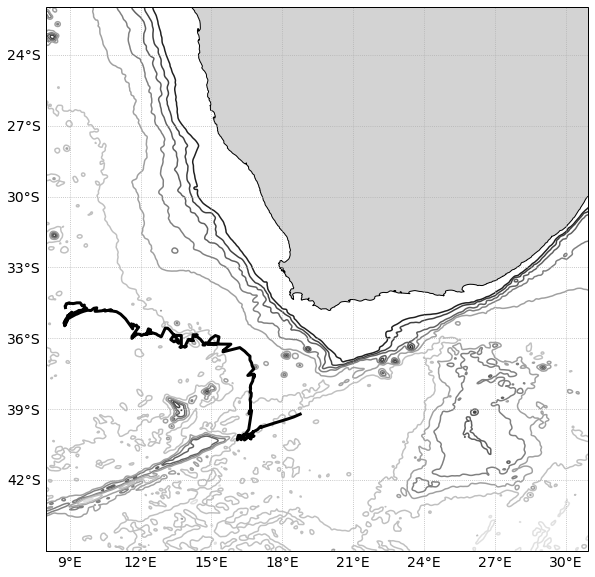

In [36]:
#plot the trajectories of these eddies
proj=ccrs.PlateCarree()  
#features 
step=15
land_10m=cfeature.NaturalEarthFeature(category='physical',
                                      name='land',
                                      scale='10m',
                                      edgecolor='k',
                                      facecolor='lightgrey')
#the plot in loop
fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
    #ax.add_feature(cfeature.COASTLINE)     #Add Coastlines
gl=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
ax.add_feature(land_10m)
    #Let's plot Bathymetry
ctf = ax.contour(lon,lat,bathy,cmap='gray')
ax.plot(loneddy1,lateddy1,'k',linewidth=3)
fig.savefig("Traj7774.png")